# Misc
Optimus class is here for fast iteration, maybe should use as seperate module later

Maybe fix retain_graph if speed is a bottleneck


# Setup

Make sure you're in the spar-red-tem/owen directory

In [68]:
# %cd ..
# !pip install --upgrade transformers
# !pip3 install torch torchvision

# !pip install -r ~/GENIES/requirements.txt
# !nvidia-smi
# %ls

In [4]:
import torch
from transformers import Trainer, TrainingArguments

import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm

# import pandas as pd

# import numpy as np
# import datasets
# import accelerate

In [5]:
# !python -m bitsandbytes

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [7]:
# A string from wikipedia about shaq
shaq = "Shaquille O'Neal is a 7-foot-1-inch (2.16 m) and 325-pound (147 kg) center who played for six teams over his 19-year career in the National Basketball Association (NBA) and is a four-time NBA champion. O'Neal is regarded as one of the greatest basketball players and centers of all time."
# A string from wikipedia about benzene
benzene = "Benzene is a natural constituent of petroleum and is one of the elementary petrochemicals. Due to the cyclic continuous pi bonds between the carbon atoms, benzene is classed as an aromatic hydrocarbon. Benzene is a colorless and highly flammable liquid with a sweet smell, and is partially responsible for the aroma of gasoline."


# Optimus (code copied here for iteration)

In [8]:
# from Optimus_dir.code.Optimus import Optimus

In [9]:
# from Optimus_dir.code.Optimus import Optimus
#Should check if optimus can encode-decode successfully
#Adapted from run_latent_generation.py
from __future__ import absolute_import, division, print_function, unicode_literals

# import argparse
# import glob
# import logging
import os
# import pickle
# import random
from typing import Tuple, Union, Any, Dict, List


import torch
import torch.nn.functional as F
import numpy as np
# import gen_utils as utils # helper functions originally in run_latent_generation.py
# from .Args import Args 

# from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler, TensorDataset
# from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

# PARENT = 'Optimus_dir.code'
from Optimus_dir.code.pytorch_transformers import GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig, BertConfig
from Optimus_dir.code.pytorch_transformers import GPT2Tokenizer, GPT2ForLatentConnector #, GPT2LMHeadModel, 
# from .pytorch_transformers import OpenAIGPTLMHeadModel, OpenAIGPTTokenizer
# from .pytorch_transformers import XLNetLMHeadModel, XLNetTokenizer
# from .pytorch_transformers import TransfoXLLMHeadModel, TransfoXLTokenizer
from Optimus_dir.code.pytorch_transformers import BertForLatentConnector, BertTokenizer

from collections import defaultdict
from Optimus_dir.code.examples.big_ae.modules import VAE 
# from .examples.big_ae.utils import (TextDataset_Split, TextDataset_2Tokenizers, BucketingDataLoader)

# import pdb

class Optimus:
    MAX_LENGTH = int(10000)  # Hardcoded max length to avoid infinite loop

    ALL_MODELS = sum((tuple(conf.pretrained_config_archive_map.keys()) for conf in (GPT2Config, OpenAIGPTConfig, XLNetConfig, TransfoXLConfig)), ())

    MODEL_CLASSES = {
        'gpt2': (GPT2Config, GPT2ForLatentConnector, GPT2Tokenizer),
        'bert': (BertConfig, BertForLatentConnector, BertTokenizer)
    }

    # Padding text to help Transformer-XL and XLNet with short prompts as proposed by Aman Rusia
    # in https://github.com/rusiaaman/XLNet-gen#methodology
    # and https://medium.com/@amanrusia/xlnet-speaks-comparison-to-gpt-2-ea1a4e9ba39e
    PADDING_TEXT = """ In 1991, the remains of Russian Tsar Nicholas II and his family
    (except for Alexei and Maria) are discovered.
    The voice of Nicholas's young son, Tsarevich Alexei Nikolaevich, narrates the
    remainder of the story. 1883 Western Siberia,
    a young Grigori Rasputin is asked by his father and a group of men to perform magic.
    Rasputin has a vision and denounces one of the men as a horse thief. Although his
    father initially slaps him for making such an accusation, Rasputin watches as the
    man is chased outside and beaten. Twenty years later, Rasputin sees a vision of
    the Virgin Mary, prompting him to become a priest. Rasputin quickly becomes famous,
    with people, even a bishop, begging for his blessing. <eod> </s> <eos>"""

    def __init__(self, latent_size=32, beta=0.5) -> None:
        """_summary_

        Args:
            latent_size (int, optional): _description_. Defaults to 32.
            beta (float, optional): _description_. Defaults to 0.5.

        Raises:
            ValueError: _description_
        """        
        # no model choice for now, fix architecture and checkpoint for simplicity?

        directory = 'Optimus_dir/code/checkpoints' # edit if file structure changes
        self.latent_size = latent_size
        self.num_layers = 12 # correct for GPT-2
        self.hidden_size = 768 # correct for GPT-2

        train_data_file = f'{directory}/train.txt'
        eval_data_file = f'{directory}/test.txt'
        if latent_size == 768 and beta == 0.5:
            checkpoint_dir = f'{directory}/optimus_latent768_beta05'
            self.latent_size = 768
        # elif latent_size == 768 and beta == 1.0:
        #     checkpoint_dir = f'{directory}/optimus_latent768_beta1'
        elif latent_size == 32:
            checkpoint_dir = f'{directory}/optimus_latent32_beta05'
            self.latent_size = 32
        else:
            raise ValueError('Only latent size 32 and 768 supported')
        # checkpoint_dir = f'{directory}/optimus_latent32_beta05'
        
        output_dir = f'{directory}/outputs'
        # train_data_file = None
        # eval_data_file = None
        # output_dir = None

        args = Args(train_data_file, eval_data_file, checkpoint_dir, output_dir)
        # args.device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
        self.device = args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        args.n_gpu = torch.cuda.device_count()
        args.latent_size = latent_size
        # args.beta = beta

        Optimus.set_seed(args)

        global_step = args.gloabl_step_eval

        output_encoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-encoder-{}'.format(global_step))
        output_decoder_dir = os.path.join(args.checkpoint_dir, 'checkpoint-decoder-{}'.format(global_step)) 
        checkpoints = [ [output_encoder_dir, output_decoder_dir] ]

        # Load a trained Encoder model and vocabulary that you have fine-tuned
        encoder_config_class, encoder_model_class, encoder_tokenizer_class = Optimus.MODEL_CLASSES[args.encoder_model_type]
        model_encoder = encoder_model_class.from_pretrained(output_encoder_dir, latent_size=args.latent_size)
        tokenizer_encoder = encoder_tokenizer_class.from_pretrained(args.encoder_tokenizer_name if args.encoder_tokenizer_name else args.encoder_model_name_or_path, do_lower_case=args.do_lower_case)
        self.tokenizer_encoder = tokenizer_encoder
        
        model_encoder.to(args.device)
        if args.block_size <= 0:
            args.block_size = tokenizer_encoder.max_len_single_sentence  # Our input block size will be the max possible for the model
        args.block_size = min(args.block_size, tokenizer_encoder.max_len_single_sentence)
        decoder_config_class, decoder_model_class, decoder_tokenizer_class = Optimus.MODEL_CLASSES[args.decoder_model_type]

        model_decoder = decoder_model_class.from_pretrained(
            output_decoder_dir, latent_size=args.latent_size,
            output_hidden_states=True, # added, hopefully doesn't break rest of code lol
            )
        self.model_decoder_with_hidden = decoder_model_class.from_pretrained(output_decoder_dir, latent_size=args.latent_size, output_hidden_states=True)
        #     tokenizer_decoder = decoder_tokenizer_class.from_pretrained(args.decoder_tokenizer_name if args.decoder_tokenizer_name else args.decoder_model_name_or_path, do_lower_case=args.do_lower_case)
        # tokenizer_decoder = AutoTokenizer.from_pretrained("gpt2", use_fast = False) # shitty fix for decoder tokenizer
        tokenizer_decoder = GPT2Tokenizer.from_pretrained("gpt2") # shitty fix for decoder tokenizer
        self.tokenizer_decoder = tokenizer_decoder
        model_decoder.to(args.device)
        if args.block_size <= 0:
            args.block_size = tokenizer_decoder.max_len_single_sentence  # Our input block size will be the max possible for the model
        args.block_size = min(args.block_size, tokenizer_decoder.max_len_single_sentence)

        # Load full model
        output_full_dir    = os.path.join(args.checkpoint_dir, 'checkpoint-full-{}'.format(global_step)) 
        checkpoint = torch.load(os.path.join(output_full_dir, 'training.bin'), map_location=self.device)

        # Chunyuan: Add Padding token to GPT2
        special_tokens_dict = {'pad_token': '<PAD>', 'bos_token': '<BOS>', 'eos_token': '<EOS>'}
        num_added_toks = tokenizer_decoder.add_special_tokens(special_tokens_dict)
        print('We have added', num_added_toks, 'tokens to GPT2')
        model_decoder.resize_token_embeddings(len(tokenizer_decoder))  # Notice: resize_token_embeddings expect to receive the full size of the new vocabulary, i.e. the length of the tokenizer.
        assert tokenizer_decoder.pad_token == '<PAD>'

        self.model_vae = VAE(model_encoder, model_decoder, tokenizer_encoder, tokenizer_decoder, args)
        self.model_vae.load_state_dict(checkpoint['model_state_dict'])
        self.model_vae.to(args.device)
        # self.tokenizer_encoder = 
        self.args = args

        bos_id = self.model_vae.tokenizer_decoder.encode('<BOS>')
        bos_id = torch.tensor(bos_id, dtype=torch.long, device=self.device)
        self.bos_id = bos_id.unsqueeze(0).repeat(1, 1)  

    def set_seed(args):
        np.random.seed(args.seed)
        torch.manual_seed(args.seed)
        if args.n_gpu > 0:
            torch.cuda.manual_seed_all(args.seed)
    
    def latent_code_from_text(self, text: str,) -> Tuple[torch.Tensor, int]:
        """_summary_

        Args:
            text (str): _description_

        Returns:
            Tuple[torch.Tensor, int]: _description_
        """        
        tokenized1 = self.model_vae.tokenizer_encoder.encode(text)
        tokenized1 = [101] + tokenized1 + [102] # Change this so same tokens in both methods
        coded1 = torch.Tensor([tokenized1])
        coded1 =torch.Tensor.long(coded1)
        with torch.no_grad():
            x0 = coded1
            x0 = x0.to(self.args.device)
            pooled_hidden_fea = self.model_vae.encoder(x0, attention_mask=(x0 > 0).float())[1]
            mean, logvar = self.model_vae.encoder.linear(pooled_hidden_fea).chunk(2, -1)
            latent_z = mean.squeeze(1)  
            coded_length = len(tokenized1)
            return latent_z, coded_length

    # def logits_from_latent_code(self, latent_z,):
    #     # Logits from which position? What did the paper do?
    #     raise NotImplementedError

    def print_n_texts_from_latent_code(self, latent_z: torch.Tensor, n=5, perturb=0.0) -> None:
        """_summary_

        Args:
            latent_z (torch.Tensor): _description_
            n (int, optional): _description_. Defaults to 5.
        """        
        for i in range(n):
            text_x1 = self.text_from_latent_code(latent_z, perturb)
            print(f'Decoding {i+1}: {text_x1}')

    def extract_last_token(hidden_states_tuple: Tuple[torch.Tensor], stack=False) -> Union[torch.Tensor, Tuple[torch.Tensor]]:
        """also turns on grad

        Args:
            hidden_states_tuple (Tuple[torch.Tensor]): _description_
            stack (bool, optional): _description_. Defaults to False.

        Returns:
            Union[torch.Tensor, Tuple[torch.Tensor]]: _description_
        """             
        # old_shape = hidden_states_tuple[0].shape
        # new_shape = (old_shape[0], 1, old_shape[2])
        # print(f'old shape: {old_shape}, new shape: {new_shape}')
        hidden_states_list = []
        for i in range(len(hidden_states_tuple)):
            last_token_only = hidden_states_tuple[i][:, -1, :].requires_grad_(True) # for some reason this loses a dimension, also not sure if I need to clone
            last_token_only = last_token_only.unsqueeze(1) # may not work if batch size is not 1?
            hidden_states_list.append(last_token_only)
            # assert last_token_only.shape == new_shape, f'Expected shape {new_shape}, got {last_token_only.shape}'
        if stack:
            shape = hidden_states_tuple[0].shape

            stacked = torch.stack(hidden_states_tuple)
            assert stacked[0].shape == shape
            return stacked
        else:
            return tuple(hidden_states_list)

    def hidden_from_latent_with_grad(self, latent_z: torch.Tensor,)-> Dict[str, Any]:
        """Just calls text_from_latent_code with use_grad=True and returns hidden states
        Convenience method for backprop
        Use greedy sampling for differentiability

        Args:
            latent_z (torch.Tensor): _description_

        Returns:
            Tuple[str, Tuple[torch.Tensor, ...]]: _description_
        """        
        return self.text_from_latent_code(latent_z, return_dict=True, greedy=True, use_grad=True)

    def text_from_latent_code(self, latent_z: torch.Tensor, perturb=0.0, return_hidden=False, greedy=False, use_grad=False, return_dict=False) -> str:
        """_summary_

        Args:
            latent_z (torch.Tensor): shape (1, latent_size)
            perturb (float, optional): _description_. Defaults to 0.0.

        Returns:
            str
        """    
        if return_dict:
            return_hidden = True    

        past = latent_z + torch.randn_like(latent_z) * perturb * torch.norm(latent_z)
        BOS_token = self.tokenizer_decoder.encode('<BOS>')

        length = 150 # maximum length
        out = Optimus.sample_sequence_conditional(
            model=self.model_vae.decoder,
            context=BOS_token,
            past=past,
            length= length, # Chunyuan: Fix length; or use <EOS> to complete a sentence
            temperature=self.args.temperature,
            top_k=self.args.top_k,
            top_p=self.args.top_p,
            device=self.args.device,
            decoder_tokenizer = self.tokenizer_decoder,
            return_hidden = return_hidden,
            greedy=greedy,
            use_grad=use_grad,
        )
        if return_hidden:
            out, hidden = out
            for tensor in hidden:
                tensor.requires_grad_(True)
        tokens = out[0,:].tolist()
        text_x1 = self.tokenizer_decoder.decode(tokens, clean_up_tokenization_spaces=True)
        text_x1 = text_x1.split()[1:-1]
        text_x1 = ' '.join(text_x1)
        
        if return_dict:
            res = {'hidden': hidden, 'text': text_x1, 'num_tokens': len(tokens)}
            return res
        elif return_hidden:
            return text_x1, hidden, len(tokens)
        else:
            return text_x1
    
    def get_token_ids(self, text: str) -> List[int]:
        """also prepends BOS token

        Args:
            text (str): _description_

        Returns:
            List[int]: _description_
        """        
        token_ids = self.model_vae.tokenizer_decoder.encode('<BOS>' + text)
        token_ids = torch.tensor(token_ids, dtype=torch.long, device=self.device)
        return token_ids.unsqueeze(0)

    def text_to_latent_to_text_activations(self, text: str, averaging_num=1, greedy=True) -> torch.Tensor:
        """given text, encode into latent, then generate averaging_num times with latent and BOS, and return averaged activations

        Args:
            text (str): _description_
            averaging_num (int, optional): number of times to generate text and average hidden state. Defaults to 1.

        Returns:
            torch.Tensor: last token activations of shape (self.num_layers + 1, 1, 1, self.latent_size)
        """       
        latent_z = self.latent_code_from_text(text)[0]
        # inputs = {'input_ids': self.bos_id, 'past': latent_z}
        # if greedy:
        #     raise NotImplementedError

        #2. Put latent through vae decoder and Get hidden state 
        for i in range(averaging_num):
            out = self.hidden_from_latent_with_grad(latent_z)
            text, hidden_states_unformatted = out['text'], out['hidden']
            hidden_states_last_token = Optimus.extract_last_token(hidden_states_unformatted)
            hidden_states_last_token = torch.stack(hidden_states_last_token)
            # hidden_states_all_tokens = torch.stack(hidden_states_unformatted) # hidden_states reformated from list of tensors to single tensor
            # hidden_states_last_token = hidden_states_all_tokens[..., -1, :]
            if i == 0:
                hidden_states_last_token_averaged = hidden_states_last_token.clone().to(self.device)
            else:
                hidden_states_last_token_averaged += hidden_states_last_token
        hidden_states_last_token_averaged /= averaging_num
        if hidden_states_last_token_averaged.shape != (self.num_layers + 1, 1, 1, self.hidden_size):
            # print(hidden_states_last_token_averaged.shape)
            raise ValueError('hidden_states_last_token_averaged has wrong shape')
        return text, hidden_states_last_token_averaged
        
        # hidden_states = self.model_decoder_with_hidden(**inputs)[2] # copied from Optimus.sample_sequence_conditional, don't know why this works
        # current_direction = torch.stack(hidden_states).view(-1) # this may stack from multiple sequence inputs, check


    def sample_sequence_conditional(
            model, length, context, past=None, num_samples=1, temperature=1, top_k=0, top_p=0.0, device='cpu', decoder_tokenizer=None, return_hidden=False,
            greedy=False, use_grad=False
            ):
        context = torch.tensor(context, dtype=torch.long, device=device)
        context = context.unsqueeze(0).repeat(num_samples, 1)
        generated = context
        eos = False
        if not use_grad:
            context = torch.no_grad()
        else:
            context = torch.enable_grad()  # This is a no-op context manager

        with context:
            # while True:
            for _ in range(length):
                inputs = {'input_ids': generated, 'past': past}
                outputs = model(**inputs)  # Note: we could also use 'past' with GPT-2/Transfo-XL/XLNet (cached hidden-states)
                next_token_logits = outputs[0][0, -1, :] / temperature
                if greedy:
                    # assert next_token_logits.shape == (50257,)
                    next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(0)
                    # generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)
                else:
                    filtered_logits = Optimus.top_k_top_p_filtering(next_token_logits, top_k=top_k, top_p=top_p)
                    next_token = torch.multinomial(F.softmax(filtered_logits, dim=-1), num_samples=1)
                generated = torch.cat((generated, next_token.unsqueeze(0)), dim=1)

                # pdb.set_trace()
                if next_token.unsqueeze(0)[0,0].item() == decoder_tokenizer.encode('<EOS>')[0]:
                    eos = True
                    break
        if not eos:
            print('Reached maximum length without <EOS> token')
        if return_hidden:
            return generated, outputs[2] # return hidden state as of generating last token
        else:
            return generated
    
    def top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=-float('Inf')):
        """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
            Args:
                logits: logits distribution shape (vocabulary size)
                top_k > 0: keep only top k tokens with highest probability (top-k filtering).
                top_p > 0.0: keep the top tokens with cumulative probability >= top_p (nucleus filtering).
                    Nucleus filtering is described in Holtzman et al. (http://arxiv.org/abs/1904.09751)
            From: https://gist.github.com/thomwolf/1a5a29f6962089e871b94cbd09daf317
        """
        assert logits.dim() == 1  # batch size 1 for now - could be updated for more but the code would be less clear
        top_k = min(top_k, logits.size(-1))  # Safety check
        if top_k > 0:
            # Remove all tokens with a probability less than the last token of the top-k
            indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[indices_to_remove] = filter_value

        if top_p > 0.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            # Remove tokens with cumulative probability above the threshold
            sorted_indices_to_remove = cumulative_probs > top_p
            # Shift the indices to the right to keep also the first token above the threshold
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0

            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[indices_to_remove] = filter_value
        return logits
    
    def is_latent(self, x):
        return isinstance(x, torch.Tensor) and x.shape == (1, self.args.latent_size)
    
    def print_text(self, *args, n=5, perturb=0.0):
        for arg in args:
            if isinstance(arg, str):
                print(f'"{arg}" encoded and decoded:')
                latent = self.latent_code_from_text(arg)[0]
            elif self.is_latent(arg):
                latent = arg
            else:
                raise ValueError('Input must be string or latent')
            self.print_n_texts_from_latent_code(latent, n, perturb)
            print('\n')
    
    def interpolate(self, num_interpolation_steps):   
        latent_z1, coded_length1 = self.latent_code_from_text()
        latent_z2, coded_length2 = self.latent_code_from_text(self.args.sent_target, self.tokenizer_encoder, self.model_vae, self.args)

        result = defaultdict(str)

        num_steps = num_interpolation_steps + 1
        for step in range(num_steps+1):
            latent_z = latent_z1 + (latent_z2 - latent_z1) * step * 1.0/num_steps
            
            text_interpolate = self.text_from_latent_code(latent_z, self.model_vae, self.args, self.tokenizer_decoder)
            result[step] = text_interpolate
            print(text_interpolate)

        return result
    
    def print_greedy(self, latent):
        text = self.text_from_latent_code(latent, greedy=True)
        print(text)


class Args:
    #     parser = argparse.ArgumentParser()
    def __init__(self, train_data_file, eval_data_file, checkpoint_dir, output_dir, checkpoint_number=508523):
        #     parser.add_argument("--train_data_file", default=None, type=str, required=True,
        #                         help="The input training data file (a text file).")
        self.train_data_file = train_data_file
        #     parser.add_argument("--eval_data_file", default=None, type=str,
        #                         help="An input evaluation data file to evaluate the perplexity on (a text file).")
        self.eval_data_file = eval_data_file
        #     parser.add_argument("--checkpoint_dir", default=None, type=str, required=True,
        #                         help="The directory where checkpoints are saved.")
        self.checkpoint_dir = checkpoint_dir
        #     parser.add_argument("--output_dir", default=None, type=str, required=True,
        #                         help="The output directory where the model predictions and checkpoints will be written.")
        self.output_dir = output_dir
        #     parser.add_argument("--dataset", default='Snli', type=str, help="The dataset.")
        self.dataset = 'Snli' # may have to change to wiki?

        #     ## Variational auto-encoder
        #     parser.add_argument("--latent_size", default=32, type=int, help="Latent space dimension.")
        self.latent_size = 768
        #     parser.add_argument("--total_sents", default=10, type=int, help="Total sentences to test recontruction.")
        self.total_sents = 10
        #     parser.add_argument("--num_interpolation_steps", default=10, type=int, help="Total sentences to test recontruction.")
        self.num_interpolation_steps = 10
        #     parser.add_argument("--play_mode", default="interpolation", type=str,
        #                         help="interpolation or reconstruction.")
        self.play_mode = "interpolation"


        #     ## Encoder options
        #     parser.add_argument("--encoder_model_type", default="bert", type=str,
        #                         help="The encoder model architecture to be fine-tuned.")
        self.encoder_model_type = "bert"
        #     parser.add_argument("--encoder_model_name_or_path", default="bert-base-cased", type=str,
        #                         help="The encoder model checkpoint for weights initialization.")
        self.encoder_model_name_or_path = "bert-base-cased"
        #     parser.add_argument("--encoder_config_name", default="", type=str,
        #                         help="Optional pretrained config name or path if not the same as model_name_or_path")
        self.encoder_config_name = ""
        #     parser.add_argument("--encoder_tokenizer_name", default="", type=str,
        #                         help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
        self.encoder_tokenizer_name = ""

            ## Decoder options
        #     parser.add_argument("--decoder_model_type", default="gpt2", type=str,
        #                         help="The decoder model architecture to be fine-tuned.")
        self.decoder_model_type = "gpt2"
        #     parser.add_argument("--decoder_model_name_or_path", default="bert-base-cased", type=str,
        #                         help="The decoder model checkpoint for weights initialization.")
        self.decoder_model_name_or_path = "bert-base-cased"
        #     parser.add_argument("--decoder_config_name", default="", type=str,
        #                         help="Optional pretrained config name or path if not the same as model_name_or_path")
        self.decoder_config_name = ""
        #     parser.add_argument("--decoder_tokenizer_name", default="", type=str,
        #                         help="Optional pretrained tokenizer name or path if not the same as model_name_or_path")
        self.decoder_tokenizer_name = ""

        #     parser.add_argument("--per_gpu_train_batch_size", default=1, type=int,
        #                         help="Batch size per GPU/CPU for training.")
        self.per_gpu_train_batch_size = 1
        #     parser.add_argument("--per_gpu_eval_batch_size", default=1, type=int,
        #                         help="Batch size per GPU/CPU for evaluation.")
        self.per_gpu_eval_batch_size = 1
        #     parser.add_argument('--gloabl_step_eval', type=int, default=661,
        #                         help="Evaluate the results at the given global step")
        self.gloabl_step_eval = checkpoint_number
        #     parser.add_argument("--max_seq_length", default=512, type=int,
        #                         help="Optional input sequence length before tokenization. The sequence will be dropped if it is longer the max_seq_length")
        self.max_seq_length = 512
        #     # Interact with users
        #     parser.add_argument("--interact_with_user_input", action='store_true', help="Use user input to interact_with.")
        self.interact_with_user_input = False
        #     parser.add_argument("--sent_source", type=str, default="")
        self.sent_source = ""
        #     parser.add_argument("--sent_target", type=str, default="")
        self.sent_target = ""
        #     parser.add_argument("--sent_input", type=str, default="")
        self.sent_input = ""
        #     parser.add_argument("--degree_to_target", type=float, default="1.0")
        self.degree_to_target = 1.0

        #     ## Variational auto-encoder
        #     parser.add_argument("--nz", default=32, type=int,
        #                         help="Latent space dimension.")
        self.nz = 32

        #     parser.add_argument("--prompt", type=str, default="")
        self.prompt = ""
        #     parser.add_argument("--padding_text", type=str, default="")
        self.padding_text = ""
        #     parser.add_argument("--length", type=int, default=20)
        self.length = 20
        #     parser.add_argument("--temperature", type=float, default=1.0)
        self.temperature = 1.0
        #     parser.add_argument("--top_k", type=int, default=0)
        self.top_k = 0
        #     parser.add_argument("--top_p", type=float, default=1.0)
        self.top_p = 1.0
        #     parser.add_argument("--no_cuda", action='store_true',
        #                         help="Avoid using CUDA when available")
        self.no_cuda = False
        #     parser.add_argument('--seed', type=int, default=42,
        #                         help="random seed for initialization")
        self.seed = 42

        #     parser.add_argument("--block_size", default=-1, type=int,
        #                         help="Optional input sequence length after tokenization."
        #                              "The training dataset will be truncated in block of this size for training."
        #                              "Default to the model max input length for single sentence inputs (take into account special tokens).")
        self.block_size = -1
        #     parser.add_argument("--do_lower_case", action='store_true',
        #                         help="Set this flag if you are using an uncased model.")
        self.do_lower_case = False

        #     parser.add_argument("--use_philly", action='store_true',
        #                         help="Use Philly for computing.")
        self.use_philly = False

        #     args = parser.parse_args()

# Instantiate Optimus

In [10]:
#TODO decouple from Optimus
vae32 = Optimus(32)

We have added 3 tokens to GPT2


Load Optimus with latent_size 32

Load Optimus with latent_size 768

In [76]:
# vae768 = Optimus(768)

# Compare effect of latent size

Seems like latent_size=32 makes the sentences "closer"? But reconstruction seems worse

Observations:
- Some latents get "translated" into either nothing or seemingly meaningless rambling. Some latents produce semantically similar words though.
- Longer sentences seem to reconstruct better than words/short sentences?

In [77]:
# hidden = vae32.get_activations(vae32.latent_code_from_text('hello')[0], 'hello')
# print (hidden.shape)

In [78]:
# vae32.print_text(
#     "love", 
#     'hate', 
#     'I love you so much!', 
#     'I hate you so much!'
#     )

In [79]:
# vae768.print_text(
#     "love", 
#     'hate', 
#     'I love you so much!', 
#     'I hate you so much!'
#     )

In [80]:
# vae32.print_text(shaq, benzene)
# baseline_sports = "basketball " * 20
# baseline_chemistry = "chemistry " * 20
# vae32.print_text(baseline_sports, baseline_chemistry)

In [81]:
# vae768.print_text(shaq, benzene)

In [82]:
# vae32.print_text(shaq, benzene, perturb=0.05)

In [83]:
# vae768.print_text(shaq, benzene, perturb=0.01)

In [84]:
# Test optimus
# text_love = "I love you so much!"
# latent_love = vae32.latent_code_from_text(text_love)[0]
# # text_hate = "I hate you so much!"
# # latent_hate = vae32.latent_code_from_text(text_hate)[0]
# print(latent_love.shape)
# # print(len(text_original))
# vae32.print_n_texts_from_latent_code(latent_love, 10)
# vae32.print_n_texts_from_latent_code(latent_hate, 10)
# vae32.print_n_texts_from_latent_code(latent_love - latent_hate, 10)
# vae32.print_n_texts_from_latent_code(-latent_love + latent_hate, 10)
# for i in range(10):
#     print(vae.text_from_latent_code(latent))

# Feature Visualization Trainer

In [93]:
# import matplotlib.pyplot as plt
def cosim(a, b):
    return nn.functional.cosine_similarity(a, b, dim=0)

class CustomTrainer(Trainer):
    def __init__(
        self, optimus: Optimus, target_dir, training_args, latent_module, logging_steps=1e2,
        length_reg=0.0,
        ):
        """_summary_
        Example use case: target_dir is hidden of last token of shaq
        loss is 1 - cosine_similarity(hidden - target)
        Loss transposed to be min at 0, max at 2

        Args:
            optimus (Optimus): _description_
            target_dir (_type_): _description_
            training_args (_type_): _description_
            latent (_type_): _description_
        """        
        '''
        decoder: decoder model from an Optimus VAE, must have output_hidden_states=True
        target_dir: of size (1 + num_layers, 1, 1, latent_size)
        '''
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        latent_module.to(self.device)
        super().__init__(model=latent_module, args=training_args)
        self.optimus = optimus # make sure this outputs hidden
        self.target_dir = target_dir.to(self.device).view(-1) #flattened
        # assert target_dir.shape == 
        context = optimus.model_vae.tokenizer_decoder.encode('<BOS>')
        context = torch.tensor(context, dtype=torch.long, device=self.device)
        self.context = context.unsqueeze(0).repeat(1, 1)  
        self.loss_values = []
        self.logging_steps = logging_steps
        self.length_reg = length_reg

    def compute_loss(self, latent_module, return_cosim=False,
        # return_dir=False,
        ): 
        '''
        latent is a trainable parameter/model with shape [1, latent_size]
        '''
        #1. Extract params from latent model
        latent = latent_module.get_parameter('latent').clone().requires_grad_(True)
        # inputs = {'input_ids': self.context, 'past': past}
        
        #2. Put latent through vae decoder and Get hidden state
        # hidden_states = self.decoder(**inputs)[2] 
        out = self.optimus.hidden_from_latent_with_grad(latent,) #generates until EOS and returns hidden state
        text, hidden_states_tuple, output_length = out['text'], out['hidden'], out['num_tokens']
        
        hidden_states_last_token = Optimus.extract_last_token(hidden_states_tuple)
        hidden_states_last_token = torch.stack(hidden_states_last_token) # hidden_states reformated from tuple of tensors to single tensor
        # print(f'hidden_states_last_token shape: {hidden_states_last_token.shape}')
        # hidden_states_last_token = hidden_states_all_tokens[..., -1, :]
        current_dir = hidden_states_last_token.view(-1) #flatten hidden layers into 1d vector
        if current_dir.shape != self.target_dir.shape:
            print(f'Target shape is {self.target_dir.shape} but current_dir shape is {current_dir.shape}')
            raise ValueError
        #3. Compute loss with cosine similarity between hidden states
        similarity = cosim(current_dir, self.target_dir) 
        loss = 1 - similarity + self.length_reg * output_length ** 2
        assert loss.numel() == 1, "Loss must be a scalar"
        # assert loss <= 2 and loss >= 0
        
        return (loss, similarity) if return_cosim else loss
    
    

    def train(self):

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.args.learning_rate)
        num_epochs = int(self.args.num_train_epochs)
        latent_module = self.model
        for epoch in range(num_epochs):
            # for step, batch in enumerate(self.get_train_dataloader()):
            optimizer.zero_grad()
            
            loss = self.compute_loss(latent_module)
            loss.backward(
                retain_graph=True
                )
            
            latent = latent_module.get_parameter('latent')
            if torch.all(latent.grad == 0):
                print('Latent grad is 0')

            # for name, param in self.model.named_parameters():
            #     print(f'Before step: {name}, {param.data}')

            optimizer.step()

            # After optimizer.step()
            # for name, param in self.model.named_parameters():
            #     print(f'After step: {name}, {param.data}')
            loss_scalar = loss.item()
            self.loss_values.append(loss_scalar)
            if epoch % self.logging_steps == 0:
                print(f"Epoch {epoch}")
                self.optimus.print_greedy(latent)
                print(f'Loss = 1 - cosine_similarity = {loss_scalar}')
                # print(text)
            # print(f"Epoch {epoch}, Loss: {loss.item()}")
        plt.plot(self.loss_values)
        plt.xlabel('Epoch')
        plt.ylabel('Loss = 1 - Cosine_Similarity(hidden_state, target_direction)')
        plt.show()


In [94]:
# Initialize trainer and run loop

# dummy_data = {'dummy':'dummy',} # may be needed to appease Trainer
# dummy_data = Dataset.from_dict(dummy_data)

NUM_LAYERS = 12
BATCH_SIZE = 1
SEQ_LEN = 1
HIDDEN_SIZE = 768

def train(
        optimus: Optimus, target_dir=None, lr=1e-4, num_epochs=1e3, logging_steps=100, init_norm=1.0, init_latent=None, 
        length_reg = 0.0 #1e-2
        ):
    latent_size = optimus.latent_size
    training_args = TrainingArguments(output_dir="test_trainer")
    training_args.num_train_epochs = num_epochs
    training_args.learning_rate = lr

    target_dir_shape = (NUM_LAYERS + 1, BATCH_SIZE, SEQ_LEN, HIDDEN_SIZE)
    # decoder = vae.model_decoder_with_hidden.to(device)
    if target_dir is None:
        target_dir = torch.randn(target_dir_shape).to(device) 
    else:
        assert target_dir.shape == target_dir_shape, "target_dir must have shape (NUM_LAYERS + 1, BATCH_SIZE, SEQ_LEN, HIDDEN_SIZE)"
    latent = nn.Module()
    if init_latent == None:
        param = torch.randn(1, latent_size)
        param /= param.norm() * init_norm
    else:
        assert init_latent.shape == (1, latent_size)
        param = init_latent
    param = nn.Parameter(data=param, requires_grad=True)
    param_init = param.clone().detach().to(device)
    latent.register_parameter("latent", param)
    latent.to(device)
    # original_latent = param.clone().detach().to(device)

    trainer = CustomTrainer(
        optimus, target_dir, training_args, latent, logging_steps=logging_steps,
        length_reg=length_reg,
        # train_dataset=dummy_data,
        )
    trainer.train()
    # optimus.print_greedy(latent.get_parameter('latent'))
    # latent_diff = (param - param_init).view(-1).norm()
    # print(latent_diff)
    


In [87]:
# activations = vae32.text_from_latent_code(torch.randn(1, 32).to(device), return_hidden=True)[1]
# stacked = torch.stack(activations)
# print(stacked.shape)

In [88]:
# shaq_activations = vae32.text_to_latent_to_activations(shaq, averaging_num=1)
#TODO maybe try training with regularization against length of output
shaq_latent_decoded, shaq_activations = vae32.text_to_latent_to_text_activations(shaq, greedy=True)
print(shaq_latent_decoded)
shaq_latent_norm = vae32.latent_code_from_text(shaq,)[0].norm().item()
print(shaq_latent_norm)


D'Angelo is a former professional boxer, who has won five world titles, including the WBA Light Middleweight Title, the WBA Light Middleweight Title, the WBA Light Middleweight Title, the WBA Light Middleweight Title, and the WBA Light Middleweight Title.
2.6317951679229736


In [89]:
benzene_latent_decoded, benzene_activations = vae32.text_to_latent_to_text_activations(benzene, greedy=True)
print(benzene_latent_decoded)
benzene_latent = vae32.latent_code_from_text(benzene,)[0]
benzene_latent_norm = benzene_latent.norm().item()
print(benzene_latent_norm)

It is a synthetic compound of the ethyl alcohols, ethyl alcohols, and ethyl alcohols, which are used in the manufacture of alcohols, and is used in the manufacture of alcohols, and in the manufacture of alcohols, and in the manufacture of alcohols.
2.8745837211608887


Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch 0
The first of these was the "Bergamasque" (Bergamasque) program, which was created in the late 1980s and early 1990s.
Loss = 1 - cosine_similarity = 0.33134615421295166
Epoch 50
The first of these was the "Bergamasque" (Bergamasque) in the 1990s, which was the first to be certified by the National Academy of Sciences.
Loss = 1 - cosine_similarity = 0.06741493940353394
Epoch 100
The first of the three to be inducted into the Hall of Fame was the former "D.C. United" player, John "D.C. United" Johnson.
Loss = 1 - cosine_similarity = 0.06488639116287231
Epoch 150
The first female director of the school was Mary Ann L. Smith, who was born in the United States in 1963.
Loss = 1 - cosine_similarity = 0.06043362617492676
Epoch 200
The first female director of the school was Mary Ann L. Smith, who was born in the United States in 1963.
Loss = 1 - cosine_similarity = 0.055973589420318604
Epoch 250
He is the only member of the "Pioneer" to have played in the National Football League, and 

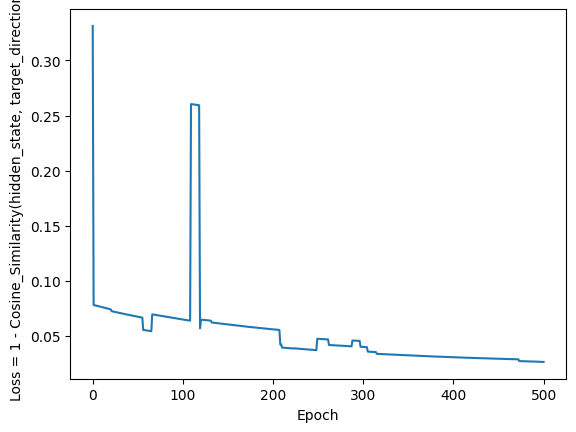

In [95]:

#TODO: maybe fix retain_graph if speed is a bottleneck
train(vae32, target_dir=shaq_activations, lr=1e-3, num_epochs=501, logging_steps=50, 
      init_norm=shaq_latent_norm,
      # init_latent=benzene_latent,
      )
# train(vae768, 768)

Seems like post training we go to one/zero word sentences (from a random init latent). Maybe will help if we init from an actual sentence

Also may be a signal that the latent space is less 'dense' with meaningful sentences than we'd like. I thought using the latent=32 vae would help as sentences will be more 'densely packed' but empirically maybe this is evidence against that.

May also need to regularize to penalize distance against actual meaningful sentences in the latent space?

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [12]:
vae32.model_vae.push_to_hub("Optimus_VAE")

AttributeError: 'VAE' object has no attribute 'push_to_hub'